<b>Notice:</b> This notebook has been created with TensorFlow version 2.2, and might not work with other versions. Therefore we check:


In [2]:
import tensorflow as tf
from IPython.display import Markdown, display
from os import listdir
from os.path import isfile, join

path = "/Users/salvatoreprioli/Documents/ML_/codes__/convolutionalNN/training_set"

In [1]:
data_set = [f for f in listdir() if isfile(join(mypath, f))]
(x_train, y_train), (x_test, y_test) =

NameError: name 'tf' is not defined

The features data are between 0 and 255, and we will normalize this to improve optimization performance.


In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0

Let's take a look at the first few label values: 


In [4]:
print(y_train[0:5])

[5 0 4 1 9]


The current label scheme simply identifies the category to which each data point belongs (each handwritten digit is assigned a category equal to the number value).  We need to convert this into a one-hot encoded vector.  In contrast to Binary representation, the labels will be presented in a way that to represent a number N, the $N^{th}$ bit is 1 while the the other bits are 0. For example, five and zero in a binary code would be:


<pre>
Number representation:    0
Binary encoding:        [2^5]  [2^4]   [2^3]   [2^2]   [2^1]   [2^0]  
Array/vector:             0      0       0       0       0       0 

Number representation:    5
Binary encoding:        [2^5]  [2^4]   [2^3]   [2^2]   [2^1]   [2^0]  
Array/vector:             0      0       0       1       0       1  
</pre>


Using a different notation, the same digits using one-hot vector representation can be show as: 


<pre>
Number representation:    0
One-hot encoding:        [5]   [4]    [3]    [2]    [1]   [0]  
Array/vector:             0     0      0      0      0     1   

Number representation:    5
One-hot encoding:        [5]   [4]    [3]    [2]    [1]    [0]  
Array/vector:             1     0      0      0      0      0   
</pre>


This is a standard operation, and is shown below.


In [5]:
print("categorical labels")
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("one hot encoded labels")
print(y_train[0:5])

categorical labels
[5 0 4 1 9]
one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


<h3>Understanding the imported data</h3>


The imported data can be divided as follows:

- Training >>  Use the given dataset with inputs and related outputs for training of NN. In our case, if you give an image that you know that represents a "nine", this set will tell the neural network that we expect a "nine" as the output.  
        - 60,000 data points
        - x_train for inputs
        - y_train for outputs/labels
  
 
- Test >> The model does not have access to this information prior to the testing phase. It is used to evaluate the performance and accuracy of the model against "real life situations". No further optimization beyond this point.  
        - 10,000 data points
        - x_test for inputs
        - y_test for outputs/labels
 
- Validation data is not used in this example.


In [6]:
print("number of training examples:" , x_train.shape[0])
print("number of test examples:" , x_test.shape[0])

number of training examples: 60000
number of test examples: 10000


The new Dataset API in TensorFlow 2.X allows you to define batch sizes as part of the dataset.  It also has improved I/O characteristics, and is the recommended way of loading data.  This allows you to iterate through  subsets (batches) of the data during training.  This is a common practice that improves performance by computing gradients over smaller batches.  We will see this in action during the training step.  

Additionally, you can shuffle the dataset if you believe that there is a skewed distribution of data in the original dataset that may result in batches with different distributions.  We aren't shuffling data here.


In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

<h3>Converting a 2D Image into a 1D Vector</h3>


MNIST images are black and white thumbnail square images with 28x28 pixels.  Each pixel is assigned an intensity (originally on a scale of 0 to 255).  To make the input useful to us, we need these to be arranged in a 1D vector using a consistent strategy, as is shown in the figure below.  We can use `Flatten` to accomplish this task.


In [8]:
# showing an example of the Flatten class and operation
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')

"original data shape"
print(x_train.shape)

"flattened shape"
print(flatten(x_train).shape)

(60000, 28, 28)
(60000, 784)


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/Flatten.png" alt="HTML5 Icon" style="width:350px">x"> 
<div style="text-align:center">Illustration of the Flatten operation </div>


<h3>Assigning bias and weights to null tensors</h3>


Now we are going to create the weights and biases, for this purpose they will be used as arrays filled with zeros. The values that we choose here can be critical, but we'll cover a better way on the second part, instead of this type of initialization.
Since these values will be adjusted during the optimization process, we define them using  `tf.Variable`.

NOTE:  `tf.Variable` creates adjustable variables that are in the global namespace, so any function that references these variables need not pass the varibles.  But they are globals, so exercise caution when naming!


In [9]:
# Weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

<h3>Adding Weights and Biases to input</h3>


The only difference for our next operation to the picture below is that we are using the mathematical convention for what is being executed in the illustration. The tf.matmul operation performs a matrix multiplication between x (inputs) and W (weights) and after the code add biases.



<img src="https://ibm.box.com/shared/static/88ksiymk1xkb10rgk0jwr3jw814jbfxo.png" alt="HTML5 Icon" style="width:350px"> 
<div style="text-align:center">Illustration showing how weights and biases are added to neurons/nodes. </div>


In [10]:
def forward(x):
    return tf.matmul(x,W) + b

<h3>Softmax Regression</h3>


Softmax is an activation function that is normally used in classification problems. It generates the probabilities for the output. For example, our model will not be 100% sure that one digit is the number nine, instead, the answer will be a distribution of probabilities where, if the model is right, the nine number will have a larger probability than the other other digits.

For comparison, below is the one-hot vector for a nine digit label:


A machine does not have all this certainty, so we want to know what is the best guess, but we also want to understand how sure it was and what was the second better option. Below is an example of a hypothetical distribution for a nine digit:


Softmax is simply an exponential of each value of a vector that is also normalized.  The formula is:

$$\sigma(z_i) = \frac{e^{z_i}}{\sum{e^{z_i}}}$$


In [11]:
# a sample softmax calculation on an input vector
vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)
print("softmax calculation")
print(softmax.numpy())
print("verifying normalization")
print(tf.reduce_sum(softmax))
print("finding vector with largest value (label assignment)")
print("category", tf.argmax(softmax).numpy())

softmax calculation
[8.8075405e-01 4.8839214e-05 1.1919710e-01]
verifying normalization
tf.Tensor(1.0, shape=(), dtype=float32)
finding vector with largest value (label assignment)
category 0


Now we can define our output layer


In [12]:
def activate(x):
    return tf.nn.softmax(forward(x))

Logistic function output is used for the classification between two target classes 0/1. Softmax function is generalized type of logistic function. That is, Softmax can output a multiclass categorical probability distribution. 


Let's create a `model` function for convenience.


In [13]:
def model(x):
    x = flatten(x)
    return activate(x)

<h3>Cost function</h3>


It is a function that is used to minimize the difference between the right answers (labels) and estimated outputs by our Network. Here we use the cross entropy function, which is a popular cost function used for categorical models.  The function is defined in terms of probabilities, which is why we must used normalized vectors.  It is given as:

$$ CrossEntropy = \sum{y_{Label}\cdot \log(y_{Prediction})}$$


In [14]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))
# addition of 1e-10 to prevent errors in zero calculations

# current loss function for unoptimized model
cross_entropy(y_train, model(x_train)).numpy()

138155.0

<h3>Type of optimization: Gradient Descent</h3>


This is the part where you configure the optimizer for your Neural Network. There are several optimizers available, in our case we will use Gradient Descent because it is a well established optimizer.


In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

Now we define the training step.  This step uses `GradientTape` to automatically compute deriviatives of the functions we have manually created and applies them using the `SGD` optimizer. 


In [16]:
def train_step(x, y ):
    with tf.GradientTape() as tape:
        #compute loss function
        current_loss = cross_entropy( y, model(x))
        # compute gradient of loss 
        #(This is automatic! Even with specialized funcctions!)
        grads = tape.gradient( current_loss , [W,b] )
        # Apply SGD step to our Variables W and b
        optimizer.apply_gradients( zip( grads , [W,b] ) )     
    return current_loss.numpy()

<h3>Training batches</h3>


Train using minibatch Gradient Descent.

In practice, Batch Gradient Descent is not often used because is too computationally expensive. The good part about this method is that you have the true gradient, but with the expensive computing task of using the whole dataset in one time. Due to this problem, Neural Networks usually use minibatch to train.

We have already divided our full dataset into batches of 50 each using the Datasets API.  Now we can iterate through each of those batches to compute a gradient.  Once we iterate through all of the batches in the dataset, we complete an **epoch**, or a full traversal of the dataset.


In [17]:
# zeroing out weights in case you want to run this cell multiple times
# Weight tensor
W = tf.Variable(tf.zeros([784, 10],tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10],tf.float32))

loss_values=[]
accuracies = []
epochs = 10

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%500==0: #reporting intermittent batch statistics
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss) ) 
    
    # collecting statistics at each epoch...loss function and accuracy
    #  loss function
    current_loss = cross_entropy( y_train, model( x_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(model(x_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) ) 


epoch  0 batch 500 loss: 177.26141
epoch  0 batch 1000 loss: 174.39491
end of epoch  0 loss 223471.0 accuracy 0.8147
epoch  1 batch 500 loss: 153.2364
epoch  1 batch 1000 loss: 178.1075
end of epoch  1 loss 216641.61 accuracy 0.824
epoch  2 batch 500 loss: 209.28334
epoch  2 batch 1000 loss: 172.85431
end of epoch  2 loss 207265.33 accuracy 0.83315
epoch  3 batch 500 loss: 203.7942
epoch  3 batch 1000 loss: 152.35666
end of epoch  3 loss 210062.88 accuracy 0.8303
epoch  4 batch 500 loss: 189.21526
epoch  4 batch 1000 loss: 163.97006
end of epoch  4 loss 211364.33 accuracy 0.82985
epoch  5 batch 500 loss: 215.90894
epoch  5 batch 1000 loss: 175.0403
end of epoch  5 loss 202569.7 accuracy 0.83845
epoch  6 batch 500 loss: 200.97389
epoch  6 batch 1000 loss: 167.53844
end of epoch  6 loss 207683.55 accuracy 0.83435
epoch  7 batch 500 loss: 200.98653
epoch  7 batch 1000 loss: 185.46494
end of epoch  7 loss 200680.2 accuracy 0.8413333
epoch  8 batch 500 loss: 213.95403
epoch  8 batch 1000 lo

<h3>Test and Plots</h3>


It is common to run intermittent diagnostics (such as accuracy and loss over entire dataset) during training.  Here we compute a summary statistic on the test dataset as well.  Fitness metrics for the training data should closely match those of the test data.  If the test metrics are distinctly less favorable, this can be a sign of overfitting.


In [18]:
correct_prediction_train = tf.equal(tf.argmax(model(x_train), axis=1),tf.argmax(y_train,axis=1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(x_test), axis=1),tf.argmax(y_test, axis=1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32)).numpy()

print("training accuracy", accuracy_train)
print("test accuracy", accuracy_test)

training accuracy 0.84305
test accuracy 0.8355


<hr>


The next two plots show the performance of the optimization at each epoch.


Text(0, 0.5, 'loss')

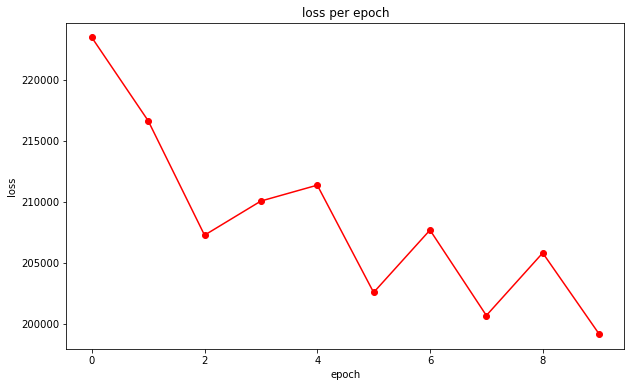

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
#print(loss_values)
plt.plot(loss_values,'-ro')
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

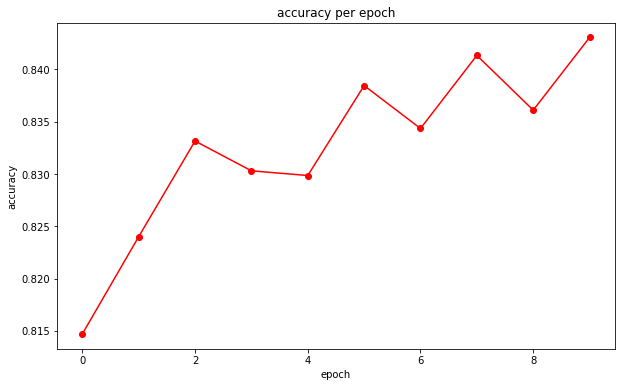

In [20]:
plt.plot(accuracies,'-ro')
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

<a id="ref4"></a>
<h2>Evaluating the final result</h2>


84% accuracy is not bad considering the simplicity of the model, but >90% accuracy has been achieved in the past.  


<a id="ref5"></a>
<h2>How to improve our model?</h2>


<h4>Several options as follow:</h4>
<ul>
    <li>Regularization of Neural Networks using DropConnect</li>
    <li>Multi-column Deep Neural Networks for Image Classification</li> 
    <li>APAC: Augmented Pattern Classification with Neural Networks</li>
    <li>Simple Deep Neural Network with Dropout</li>
</ul>
<h4>In the next part we are going to explore the option:</h4>
<ul>
    <li>Simple Deep Neural Network with Dropout (more than 1 hidden layer)</li>
</ul> 


<hr>


<a id="ref6"></a>
<h2>2nd part: Deep Learning applied on MNIST</h2>


In the first part, we learned how to use a simple ANN to classify MNIST. Now we are going to expand our knowledge using a Deep Neural Network. 


Architecture of our network is:
    
- (Input) -> [batch_size, 28, 28, 1]  >> Apply 32 filter of [5x5]
- (Convolutional layer 1)  -> [batch_size, 28, 28, 32]
- (ReLU 1)  -> [?, 28, 28, 32]
- (Max pooling 1) -> [?, 14, 14, 32]
- (Convolutional layer 2)  -> [?, 14, 14, 64] 
- (ReLU 2)  -> [?, 14, 14, 64] 
- (Max pooling 2)  -> [?, 7, 7, 64] 
- [fully connected layer 3] -> [1x1024]
- [ReLU 3]  -> [1x1024]
- [Drop out]  -> [1x1024]
- [fully connected layer 4] -> [1x10]


The next cells will explore this new architecture.


<h3>The MNIST data</h3>


The MNIST Dataset will be used from the above example.


<h3>Initial parameters</h3>


Create general parameters for the model


In [21]:
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

<h4>Converting images of the data set to tensors</h4>


The input image is 28 pixels by 28 pixels, 1 channel (grayscale). In this case, the first dimension is the <b>batch number</b> of the image, and can be of any size (so we set it to -1). The second and third dimensions are width and height, and the last one is the image channels.


In [22]:
x_image_train = tf.reshape(x_train, [-1,28,28,1])  
x_image_train = tf.cast(x_image_train, 'float32') 

x_image_test = tf.reshape(x_test, [-1,28,28,1]) 
x_image_test = tf.cast(x_image_test, 'float32') 

#creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

Reducing data set size from this point on because the Skills Netowrk Labs only provides 4 GB of main memory but 8 are needed otherwise. If you want to run faster (in multiple CPU or GPU) and on the whole data set consider using IBM Watson Studio. You get 100 hours of free usage every month. https://github.com/IBM/skillsnetwork/wiki/Watson-Studio-Setup


In [23]:
x_image_train = tf.slice(x_image_train,[0,0,0,0],[10000, 28, 28, 1])
y_train = tf.slice(y_train,[0,0],[10000, 10])

<h3>Convolutional Layer 1</h3>


<h4>Defining kernel weight and bias</h4>
We define a kernel here. The Size of the filter/kernel is 5x5;  Input channels is 1 (grayscale);  and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So, the output of convolution layer would be 28x28x32). In this step, we create a filter / kernel tensor of shape <code>[filter_height, filter_width, in_channels, out_channels]</code>


In [24]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs

<img src="https://ibm.box.com/shared/static/vn26neef1nnv2oxn5cb3uueowcawhkgb.png" style="width: 800px; height: 400px;" alt="HTML5 Icon">

</h4>Convolve with weight tensor and add biases.</h4>

To create convolutional layer, we use <b>tf.nn.conv2d</b>. It computes a 2-D convolution given 4-D input and filter tensors.

Inputs:
- tensor of shape [batch, in_height, in_width, in_channels]. x of shape [batch_size,28 ,28, 1]
- a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]. W is of size [5, 5, 1, 32]
- stride which is  [1, 1, 1, 1]. The convolutional layer, slides the "kernel window" across the input tensor. As the input tensor has 4 dimensions:  [batch, height, width, channels], then the convolution operates on a 2D window on the height and width dimensions. __strides__ determines how much the window shifts by in each of the dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we could set other values, e.g. [1, 2, 2, 1]
    
    
Process:
- Change the filter to a 2-D matrix with shape [5\*5\*1,32]
- Extracts image patches from the input tensor to form a *virtual* tensor of shape `[batch, 28, 28, 5*5*1]`.
- For each batch, right-multiplies the filter matrix and the image vector.

Output:
- A `Tensor` (a 2-D convolution) of size tf.Tensor 'add_7:0' shape=(?, 28, 28, 32)- Notice: the output of the first convolution layer is 32 [28x28] images. Here 32 is considered as volume/depth of the output image.


In [25]:
def convolve1(x):
    return(
        tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

<img src="https://ibm.box.com/shared/static/iizf4ui4b2hh9wn86pplqxu27ykpqci9.png" style="width: 800px; height: 400px;" alt="HTML5 Icon">


<h4>Apply the ReLU activation Function</h4>


In this step, we just go through all outputs convolution layer, <b>convolve1</b>, and wherever a negative number occurs, we swap it out for a 0. It is called ReLU activation Function.<br> Let f(x) is a ReLU activation function $f(x) = max(0,x)$.


In [26]:
def h_conv1(x): return(tf.nn.relu(convolve1(x)))

<h4>Apply the max pooling</h4>


<b>max pooling</b> is a form of non-linear down-sampling. It partitions the input image into a set of rectangles and, and then find the maximum value for that region. 

Lets use <b>tf.nn.max_pool</b> function to perform max pooling. 
<b>Kernel size:</b> 2x2 (if the window is a 2x2 matrix, it would result in one output pixel)  
<b>Strides:</b> dictates the sliding behaviour of the kernel. In this case it will move 2 pixels everytime, thus not overlapping. The input is a matrix of size 28x28x32, and the output would be a matrix of size 14x14x32.

<img src="https://ibm.box.com/shared/static/kmaja90mn3aud9mro9cn8pbbg1h5pejy.png" alt="HTML5 Icon" style="width: 800px; height: 400px;"> 



In [27]:
def conv1(x):
    return tf.nn.max_pool(h_conv1(x), ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

First layer completed


<h3>Convolutional Layer 2</h3>
<h4>Weights and Biases of kernels</h4>


We apply the convolution again in this layer. Lets look at the second layer kernel:  
- Filter/kernel: 5x5 (25 pixels) 
- Input channels: 32 (from the 1st Conv layer, we had 32 feature maps) 
- 64 output feature maps  

<b>Notice:</b> here, the input image is [14x14x32], the filter is [5x5x32], we use 64 filters of size [5x5x32], and the output of the convolutional layer would be 64 convolved image, [14x14x64].

<b>Notice:</b> the convolution result of applying a filter of size [5x5x32] on image of size [14x14x32] is an image of size [14x14x1], that is, the convolution is functioning on volume.


In [28]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs

<h4>Convolve image with weight tensor and add biases.</h4>


In [29]:
def convolve2(x): 
    return( 
    tf.nn.conv2d(conv1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

<h4>Apply the ReLU activation Function</h4>


In [30]:
def h_conv2(x):  return tf.nn.relu(convolve2(x))

<h4>Apply the max pooling</h4>


In [31]:
def conv2(x):  
    return(
    tf.nn.max_pool(h_conv2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'))

Second layer completed. So, what is the output of the second layer, layer2?
- it is 64 matrix of [7x7]


<h3>Fully Connected Layer</h3>


You need a fully connected layer to use the Softmax and create the probabilities in the end. Fully connected layers take the high-level filtered images from previous layer, that is all 64 matrices, and convert them to a flat array.

So, each matrix [7x7] will be converted to a matrix of [49x1], and then all of the 64 matrix will be connected, which make an array of size [3136x1]. We will connect it into another layer of size [1024x1]. So, the weight between these 2 layers will be [3136x1024]


<img src="https://ibm.box.com/shared/static/pr9mnirmlrzm2bitf1d4jj389hyvv7ey.png" alt="HTML5 Icon" style="width: 800px; height: 400px;"> 


<h4>Flattening Second Layer</h4>


In [32]:
def layer2_matrix(x): return tf.reshape(conv2(x), [-1, 7 * 7 * 64])

<h4>Weights and Biases between layer 2 and 3</h4>


Composition of the feature map from the last layer (7x7) multiplied by the number of feature maps (64); 1027 outputs to Softmax layer


In [33]:
W_fc1 = tf.Variable(tf.random.truncated_normal([7 * 7 * 64, 1024], stddev=0.1, seed = 2))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

<h4>Matrix Multiplication (applying weights and biases)</h4>


In [34]:
def fcl(x): return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

<h4>Apply the ReLU activation Function</h4>


In [35]:
def h_fc1(x): return tf.nn.relu(fcl(x))

Third layer completed


<h4>Dropout Layer, Optional phase for reducing overfitting</h4>


It is a phase where the network "forget" some features. At each training step in a mini-batch, some units get switched off randomly so that it will not interact with the network. That is, it weights cannot be updated, nor affect the learning of the other network nodes.  This can be very useful for very large neural networks to prevent overfitting.


In [36]:
keep_prob=0.5
def layer_drop(x): return tf.nn.dropout(h_fc1(x), keep_prob)

<h4>Readout Layer (Softmax Layer)</h4>


Type: Softmax, Fully Connected Layer.


<h4>Weights and Biases</h4>


In last layer, CNN takes the high-level filtered images and translate them into votes using softmax.
Input channels: 1024 (neurons from the 3rd Layer); 10 output features


In [37]:
W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed = 2)) #1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # 10 possibilities for digits [0,1,2,3,4,5,6,7,8,9]

<h4>Matrix Multiplication (applying weights and biases)</h4>


In [38]:
def fc(x): return tf.matmul(layer_drop(x), W_fc2) + b_fc2

<h4>Apply the Softmax activation Function</h4>
<b>softmax</b> allows us to interpret the outputs of <b>fcl4</b> as probabilities. So, <b>y_conv</b> is a tensor of probabilities.


In [39]:
def y_CNN(x): return tf.nn.softmax(fc(x))

---


<a id="ref7"></a>
<h2>Summary of the Deep Convolutional Neural Network</h2>


Now is time to remember the structure of  our network


#### 0) Input - MNIST dataset
#### 1) Convolutional and Max-Pooling
#### 2) Convolutional and Max-Pooling
#### 3) Fully Connected Layer
#### 4) Processing - Dropout
#### 5) Readout layer - Fully Connected
#### 6) Outputs - Classified digits


---


<a id="ref8"></a>
<h2>Define functions and train the model</h2>


<h4>Define the loss function</h4>

We need to compare our output, layer4 tensor, with ground truth for all mini_batch. we can use <b>cross entropy>/b> to see how bad our CNN is working - to measure the error at a softmax layer.

The following code shows an toy sample of cross-entropy for a mini-batch of size 2 which its items have been classified. You can run it (first change the cell type to <b>code</b> in the toolbar) to see how cross entropy changes.


<b>reduce_sum</b> computes the sum of elements of <b>(y_ * tf.log(layer4)</b> across second dimension of the tensor, and <b>reduce_mean</b> computes the mean of all elements in the tensor..

$$ CrossEntropy = \sum{y_{Label}\cdot \log(y_{Prediction})}$$


In [40]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

<h4>Define the optimizer</h4>

It is obvious that we want minimize the error of our network which is calculated by cross_entropy metric. To solve the problem, we have to compute gradients for the loss (which is minimizing the cross-entropy) and apply gradients to variables. It will be done by an optimizer: GradientDescent or Adagrad. 


In [41]:
optimizer = tf.keras.optimizers.Adam(1e-4)

Following the convention of our first example, we will use `GradientTape` to define a model.


In [42]:
variables = [W_conv1, b_conv1, W_conv2, b_conv2, 
             W_fc1, b_fc1, W_fc2, b_fc2, ]

def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy( y, y_CNN( x ))
        grads = tape.gradient( current_loss , variables )
        optimizer.apply_gradients( zip( grads , variables ) )
        return current_loss.numpy()


In [43]:
"""results = []
increment = 1000
for start in range(0,60000,increment):
    s = tf.slice(x_image_train,[start,0,0,0],[start+increment-1, 28, 28, 1])
    t = y_CNN(s)
    #results.append(t)
"""

'results = []\nincrement = 1000\nfor start in range(0,60000,increment):\n    s = tf.slice(x_image_train,[start,0,0,0],[start+increment-1, 28, 28, 1])\n    t = y_CNN(s)\n    #results.append(t)\n'

<h4>Define prediction</h4>
Do you want to know how many of the cases in a mini-batch has been classified correctly? lets count them.


In [44]:
correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))

<h4>Define accuracy</h4>
It makes more sense to report accuracy using average of correct cases.


In [45]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

<h4>Run session, train</h4>


<i>If you want a fast result (<b>it might take sometime to train it</b>)</i>


In [46]:
loss_values=[]
accuracies = []
epochs = 1

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds2:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%50==0: #reporting intermittent batch statistics
            correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
            #  accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss),
                     "accuracy", str(accuracy)) 
            
    current_loss = cross_entropy( y_train, y_CNN( x_image_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) )  

epoch  0 batch 50 loss: 133.3734 accuracy 0.32
epoch  0 batch 100 loss: 61.958702 accuracy 0.74
epoch  0 batch 150 loss: 43.210915 accuracy 0.82
epoch  0 batch 200 loss: 32.455154 accuracy 0.84
epoch  0 batch 250 loss: 33.130524 accuracy 0.82
epoch  0 batch 300 loss: 21.561773 accuracy 0.82
epoch  0 batch 350 loss: 35.900673 accuracy 0.88
epoch  0 batch 400 loss: 20.942165 accuracy 0.86
epoch  0 batch 450 loss: 31.85585 accuracy 0.8
epoch  0 batch 500 loss: 19.80085 accuracy 0.86
epoch  0 batch 550 loss: 22.676712 accuracy 0.92
epoch  0 batch 600 loss: 18.207457 accuracy 0.9
epoch  0 batch 650 loss: 20.510498 accuracy 0.86
epoch  0 batch 700 loss: 10.093265 accuracy 0.94
epoch  0 batch 750 loss: 24.73391 accuracy 0.88
epoch  0 batch 800 loss: 18.164337 accuracy 0.92
epoch  0 batch 850 loss: 14.345393 accuracy 0.92
epoch  0 batch 900 loss: 7.4678845 accuracy 0.94
epoch  0 batch 950 loss: 17.966473 accuracy 0.92
epoch  0 batch 1000 loss: 11.325726 accuracy 0.92
epoch  0 batch 1050 loss: 

<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<font size = 3><strong><i>Wow...95% accuracy after only 1 epoch!  You can increase the number of epochs in the previsous cell if you REALLY have time to wait, or you are running it using PowerAI (<b>change the type of the cell to code</b>)</i></strong></font>


<i>PS. If you have problems running this notebook, please shutdown all your Jupyter runnning notebooks, clear all cells outputs and run each cell only after the completion of the previous cell.</i>


<hr>


<a id="ref9"></a>
<h2>Evaluate the model</h2>


Print the evaluation to the user


In [47]:
j=0
acccuracies=[]
# evaluate accuracy by batch and average...reporting every 100th batch
for x_train_batch, y_train_batch in train_ds2:
        j+=1
        correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
        #accuracies.append(accuracy)
        if j%100==0:
            print("batch", str(j), "accuracy", str(accuracy) ) 
import numpy as np
print("accuracy of entire set", str(np.mean(accuracies)))            

batch 100 accuracy 0.92
batch 200 accuracy 0.98
batch 300 accuracy 0.9
batch 400 accuracy 1.0
batch 500 accuracy 0.92
batch 600 accuracy 0.9
batch 700 accuracy 0.96
batch 800 accuracy 0.98
batch 900 accuracy 0.94
batch 1000 accuracy 0.9
batch 1100 accuracy 0.88
batch 1200 accuracy 1.0
accuracy of entire set 0.9401


<h3>Visualization</h3>


Do you want to look at all the filters?


In [48]:
kernels = tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0,1]),[32, -1])

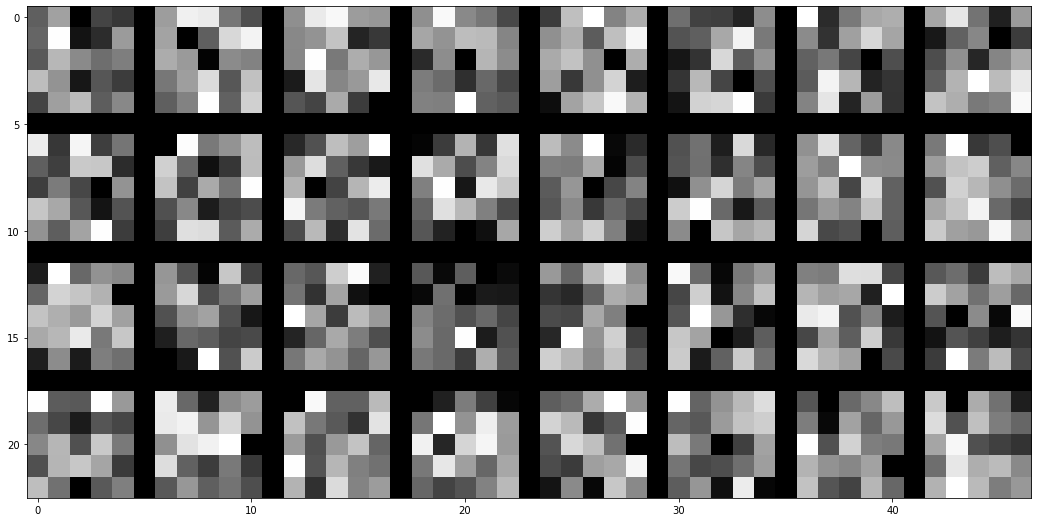

In [53]:
# !wget --output-document utils1.py https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py
import utils1
import imp
imp.reload(utils1)
from utils1 import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels.numpy(), img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Do you want to see the output of an image passing through first convolution layer?


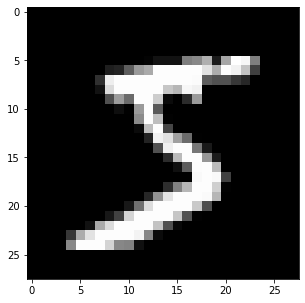

In [54]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage = [x_image_train[0]]
plt.imshow(np.reshape(sampleimage,[28,28]), cmap="gray")

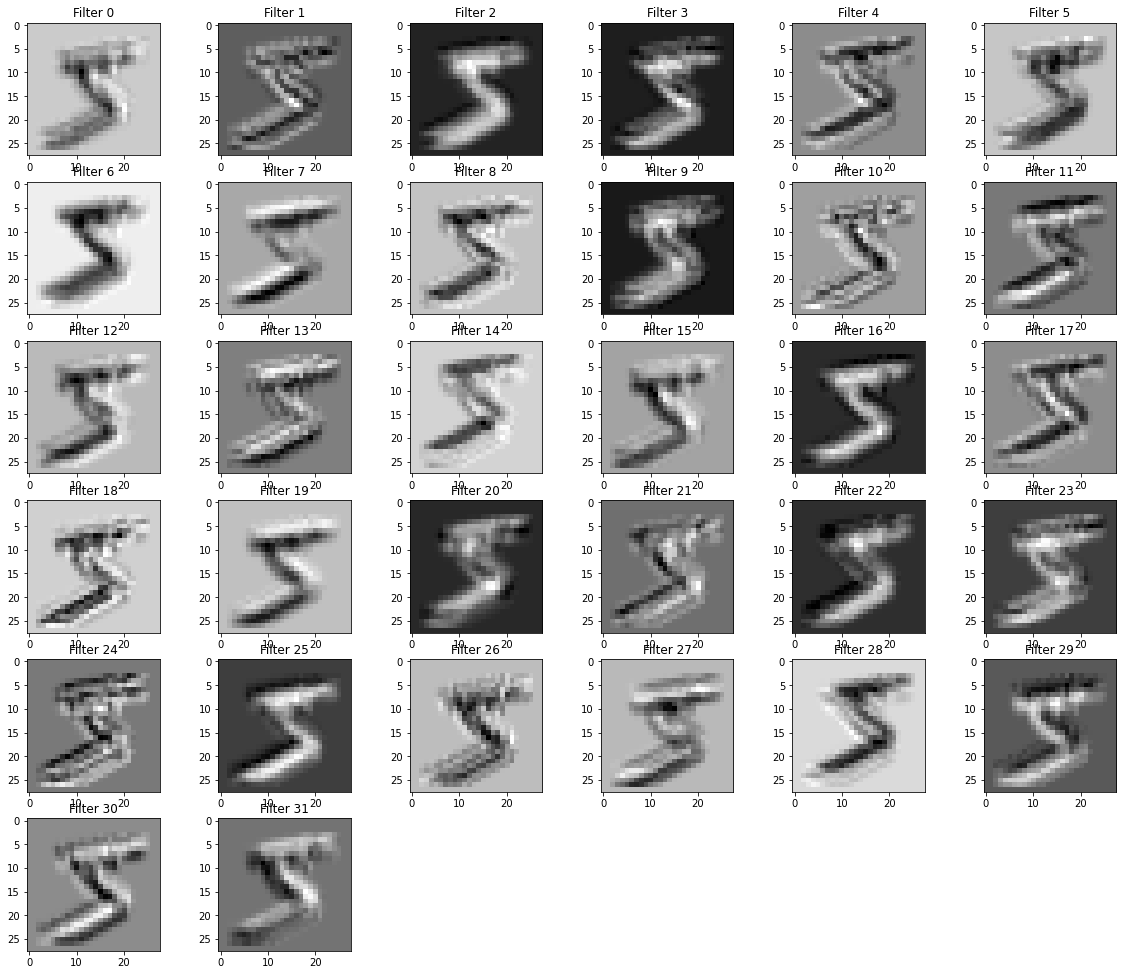

In [55]:
#ActivatedUnits = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
keep_prob=1.0
ActivatedUnits = convolve1(sampleimage)
                           
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 6
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

What about second convolution layer?


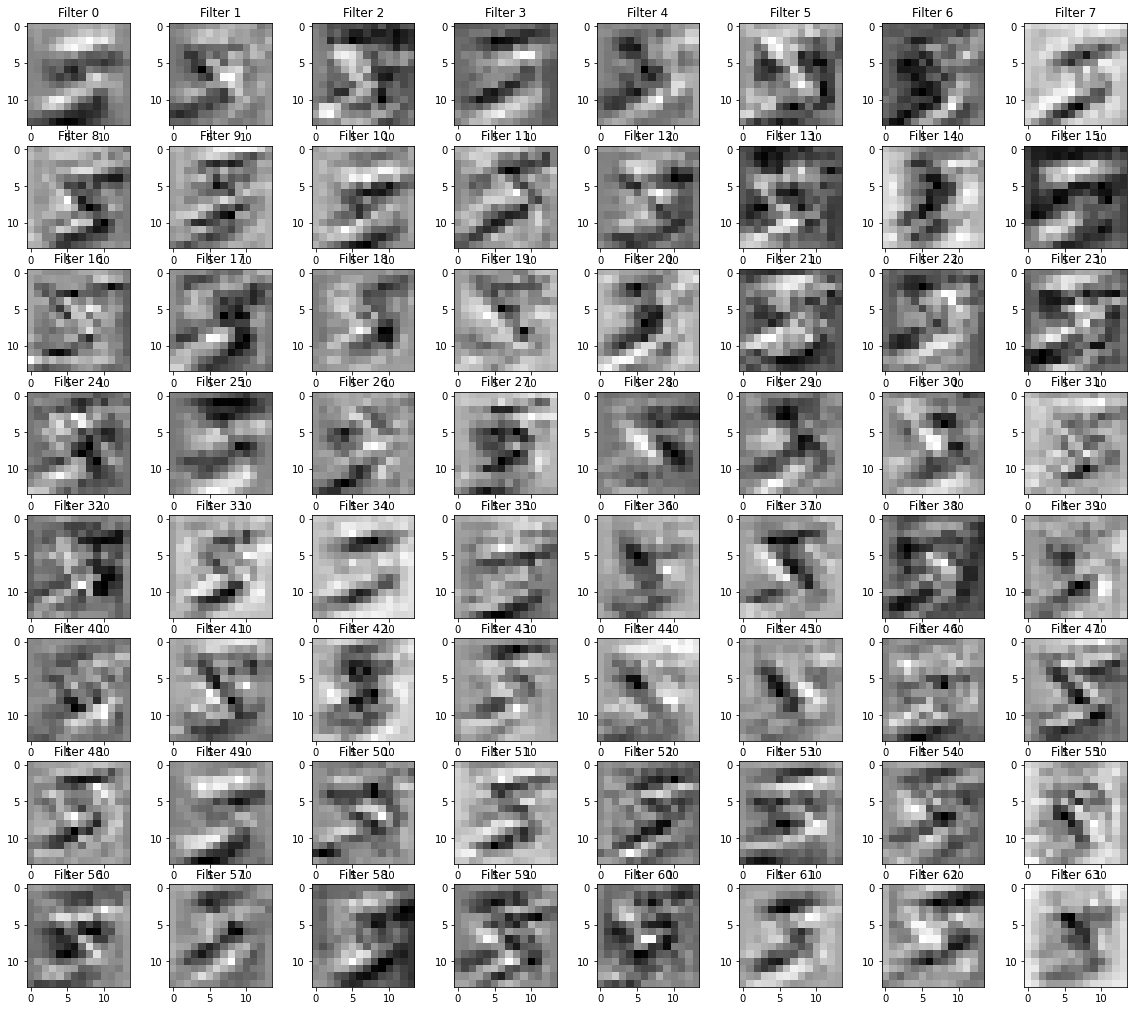

In [56]:
#ActivatedUnits = sess.run(convolve2,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
ActivatedUnits = convolve2(sampleimage)
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

## Want to learn more?

Also, you can use __Watson Studio__ to run these notebooks faster with bigger datasets.__Watson Studio__ is IBM’s leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark, and NVIDIA GPU accelerated hardware environemnts, as well as and popular libraries pre-packaged in the cloud, __Watson Studio__ enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of __Watson Studio__ users today with a free account at [Watson Studio](https://cocl.us/ML0120EN_DSX).This is the end of this lesson. Thank you for reading this notebook, and good luck on your studies.


### Thanks for completing this lesson!


Created by <a href="https://linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0120ENSkillsNetwork954-2022-01-01"> Saeed Aghabozorgi </a>, <a href="https://linkedin.com/in/luisotsm?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0120ENSkillsNetwork954-2022-01-01">Luis Otavio Silveira Martins</a>, <a href="https://linkedin.com/in/erich-natsubori-sato?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0120ENSkillsNetwork954-2022-01-01"> Erich Natsubori Sato </a></h4>

Updated to TF 2.X by  <a href="https://ca.linkedin.com/in/nilmeier?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0120ENSkillsNetwork954-2022-01-01"> Jerome Nilmeier</a><br />


### References:

https://en.wikipedia.org/wiki/Deep_learning    
http://ruder.io/optimizing-gradient-descent/<br> 
http://yann.lecun.com/exdb/mnist/  
https://www.quora.com/Artificial-Neural-Networks-What-is-the-difference-between-activation-functions  
https://www.tensorflow.org/versions/r0.9/tutorials/mnist/pros/index.html  


<hr>

Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0120ENSkillsNetwork954-2022-01-01).
